Loading data and running initial sanity checks...
Opening raw data file ../data/ds005107/sub-01/ses-01/meg/sub-01_ses-01_task-face_run-01_meg.fif...
Isotrak not found
    Range : 0 ... 325339 =      0.000 ...   325.339 secs
Ready.
Reading 0 ... 325339  =      0.000 ...   325.339 secs...
✓ Loaded 65 channels at 1000.0 Hz

6. File Information:
   - File size: 0.08 GB
Isotrak not found
   - Channels in file: 65
   - Sampling rate: 1000.0 Hz
   - Measurement date: None

=== SANITY CHECKS for subject 01 ===
1. Channel Info:
   - Total channels: 65
   - MEG channels: 64
   - EEG channels: 0
   - EOG channels: 0
   - ECG channels: 0
   - Bad channels: 0
2. Recording Info:
   - Duration: 325.3 seconds
   - Sampling rate: 1000.0 Hz
   - Samples: 325340
3. Data Quality:
   - Global min/max: -2.68e-08 / 5.50e+01
   - Global mean/std: 7.56e-05 / 5.66e-02
   - Extreme values (>99.9%): 21127 samples

4. Channel-specific Checks:
   - MEG magnetometers (64):
     Mean std: 5.20e-10 ± 2.59e-09
     Ran

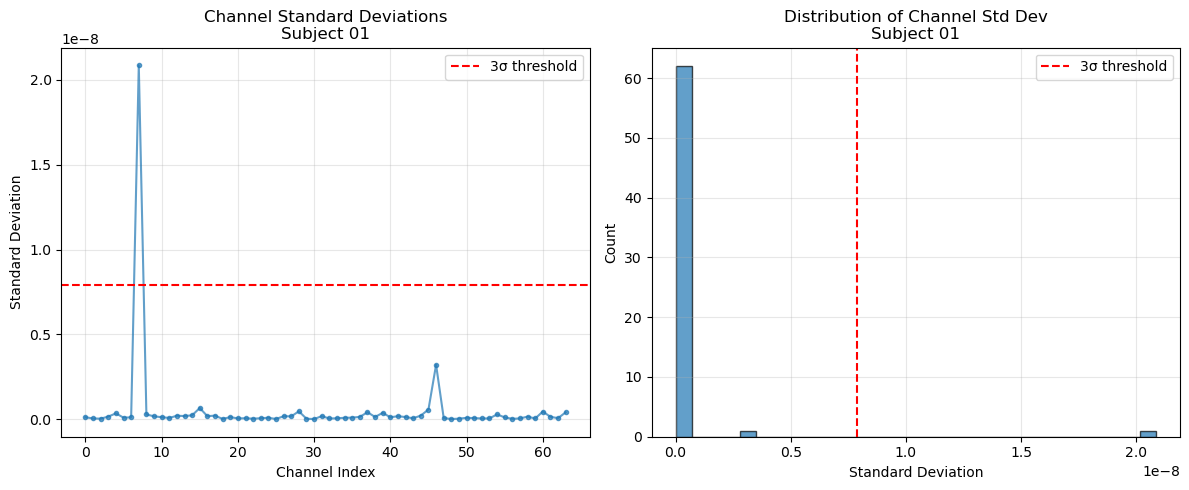

Using matplotlib as 2D backend.

INITIAL DATA QUALITY REPORT - Subject 01
************************************************************

📊 OVERALL ASSESSMENT:
   ✓ Data appears complete (325340 samples)
   ✓ Low extreme value ratio: 0.0010
   ⚠️  1 channels exceed variance threshold
   ⚠️  No EOG channels found - will need synthetic EOG
   ⚠️  No ECG channels found

🎯 NEXT STEPS:
   - Review the generated plots
   - Check for any warning signs in the report
   - Proceed with ICA preprocessing if data quality is acceptable

Data loaded successfully and ready for preprocessing!


In [7]:
import os
import mne
from mne.preprocessing import ICA
import numpy as np
import matplotlib.pyplot as plt

def load_and_check_data(subject='01', session='01', run='01'):
    """
    Load raw data and perform comprehensive sanity checks
    """
    # --- 1. Load raw data ---
    fif_path = f'../data/ds005107/sub-{subject}/ses-{session}/meg/sub-{subject}_ses-{session}_task-face_run-{run}_meg.fif'
    if not os.path.exists(fif_path):
        raise FileNotFoundError(f"File not found: {fif_path}")
    
    raw = mne.io.read_raw_fif(fif_path, preload=True)
    print(f"✓ Loaded {len(raw.ch_names)} channels at {raw.info['sfreq']} Hz")
    
    return raw

def basic_sanity_checks(raw, subject='01'):
    """Perform basic data quality checks"""
    print(f"\n=== SANITY CHECKS for subject {subject} ===")
    
    # Check 1: Channel counts and types
    print(f"1. Channel Info:")
    print(f"   - Total channels: {len(raw.ch_names)}")
    print(f"   - MEG channels: {len(mne.pick_types(raw.info, meg=True))}")
    print(f"   - EEG channels: {len(mne.pick_types(raw.info, eeg=True))}")
    print(f"   - EOG channels: {len(mne.pick_types(raw.info, eog=True))}")
    print(f"   - ECG channels: {len(mne.pick_types(raw.info, ecg=True))}")
    print(f"   - Bad channels: {len(raw.info['bads'])}")
    if raw.info['bads']:
        print(f"     Bad channel names: {raw.info['bads']}")
    
    # Check 2: Data duration and sampling
    print(f"2. Recording Info:")
    print(f"   - Duration: {raw.times[-1]:.1f} seconds")
    print(f"   - Sampling rate: {raw.info['sfreq']} Hz")
    print(f"   - Samples: {len(raw.times)}")
    
    # Check 3: Data range and quality
    data = raw.get_data()
    print(f"3. Data Quality:")
    print(f"   - Global min/max: {data.min():.2e} / {data.max():.2e}")
    print(f"   - Global mean/std: {data.mean():.2e} / {data.std():.2e}")
    
    # Check for extreme values (potential artifacts)
    extreme_threshold = np.percentile(np.abs(data), 99.9)
    extreme_count = np.sum(np.abs(data) > extreme_threshold)
    print(f"   - Extreme values (>99.9%): {extreme_count} samples")
    
    return data

def channel_specific_checks(raw, subject='01'):
    """Check individual channel quality"""
    print(f"\n4. Channel-specific Checks:")
    
    # Check MEG magnetometers
    picks_mag = mne.pick_types(raw.info, meg='mag')
    if len(picks_mag) > 0:
        ch_data = raw.get_data(picks=picks_mag)
        ch_stds = ch_data.std(axis=1)
        print(f"   - MEG magnetometers ({len(picks_mag)}):")
        print(f"     Mean std: {ch_stds.mean():.2e} ± {ch_stds.std():.2e}")
        print(f"     Range: [{ch_stds.min():.2e}, {ch_stds.max():.2e}]")
    
    # Check MEG gradiometers
    picks_grad = mne.pick_types(raw.info, meg='grad')
    if len(picks_grad) > 0:
        ch_data = raw.get_data(picks=picks_grad)
        ch_stds = ch_data.std(axis=1)
        print(f"   - MEG gradiometers ({len(picks_grad)}):")
        print(f"     Mean std: {ch_stds.mean():.2e} ± {ch_stds.std():.2e}")
        print(f"     Range: [{ch_stds.min():.2e}, {ch_stds.max():.2e}]")
    
    # Check other channel types
    for ch_type, ch_name in [('eeg', 'EEG'), ('eog', 'EOG'), ('ecg', 'ECG')]:
        picks = mne.pick_types(raw.info, **{ch_type: True})
        if len(picks) > 0:
            ch_data = raw.get_data(picks=picks)
            ch_stds = ch_data.std(axis=1)
            print(f"   - {ch_name} channels ({len(picks)}):")
            print(f"     Mean std: {ch_stds.mean():.2e} ± {ch_stds.std():.2e}")
            print(f"     Range: [{ch_stds.min():.2e}, {ch_stds.max():.2e}]")

def plot_initial_quality(raw, subject='01'):
    """Create initial quality assessment plots"""
    print(f"\n5. Generating quality plots...")
    
    # Plot 1: Channel standard deviations
    meg_picks = mne.pick_types(raw.info, meg=True)
    if len(meg_picks) > 0:
        data = raw.get_data(picks=meg_picks)
        channel_stds = data.std(axis=1)
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(channel_stds, 'o-', alpha=0.7, markersize=3)
        plt.axhline(y=np.median(channel_stds) + 3*np.std(channel_stds), 
                    color='r', linestyle='--', label='3σ threshold')
        plt.xlabel('Channel Index')
        plt.ylabel('Standard Deviation')
        plt.title(f'Channel Standard Deviations\nSubject {subject}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.hist(channel_stds, bins=30, alpha=0.7, edgecolor='black')
        plt.axvline(x=np.median(channel_stds) + 3*np.std(channel_stds), 
                    color='r', linestyle='--', label='3σ threshold')
        plt.xlabel('Standard Deviation')
        plt.ylabel('Count')
        plt.title(f'Distribution of Channel Std Dev\nSubject {subject}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'initial_channel_quality_sub-{subject}.png', dpi=150, bbox_inches='tight')
        plt.show()
    
    # Plot 2: Quick data overview
    try:
        # Plot just 2 seconds to avoid overwhelming the display
        fig = raw.plot(duration=2, n_channels=20, show=False, scalings=dict(mag=1e-12, grad=1e-10))
        fig.suptitle(f'Raw Data Overview - Subject {subject}')
        fig.savefig(f'raw_data_overview_sub-{subject}.png', dpi=150, bbox_inches='tight')
        plt.close(fig)
    except Exception as e:
        print(f"   Could not create raw data plot: {e}")

def check_file_size_and_info(fif_path, subject='01'):
    """Check file size and basic info"""
    print(f"\n6. File Information:")
    if os.path.exists(fif_path):
        file_size = os.path.getsize(fif_path) / (1024**3)  # Size in GB
        print(f"   - File size: {file_size:.2f} GB")
        
        # Read info without loading full data
        info = mne.io.read_info(fif_path)
        print(f"   - Channels in file: {len(info['ch_names'])}")
        print(f"   - Sampling rate: {info['sfreq']} Hz")
        print(f"   - Measurement date: {info['meas_date']}")

def generate_initial_report(raw, subject='01'):
    """Generate summary report of initial data quality"""
    print(f"\n{'='*60}")
    print(f"INITIAL DATA QUALITY REPORT - Subject {subject}")
    print('*' * 60)
    
    # Overall assessment
    meg_picks = mne.pick_types(raw.info, meg=True)
    data = raw.get_data(picks=meg_picks)
    channel_stds = data.std(axis=1)
    
    print(f"\n📊 OVERALL ASSESSMENT:")
    
    # Check data completeness
    if len(raw.times) > 1000:  # Arbitrary threshold
        print(f"   ✓ Data appears complete ({len(raw.times)} samples)")
    else:
        print(f"   ⚠️  Very short recording ({len(raw.times)} samples)")
    
    # Check for extreme artifacts
    extreme_ratio = np.sum(np.abs(data) > np.percentile(np.abs(data), 99.9)) / data.size
    if extreme_ratio < 0.001:
        print(f"   ✓ Low extreme value ratio: {extreme_ratio:.4f}")
    else:
        print(f"   ⚠️  High extreme value ratio: {extreme_ratio:.4f}")
    
    # Check channel variability
    bad_ch_threshold = np.median(channel_stds) + 3 * np.std(channel_stds)
    potential_bads = np.sum(channel_stds > bad_ch_threshold)
    if potential_bads == 0:
        print(f"   ✓ No obvious bad channels detected automatically")
    else:
        print(f"   ⚠️  {potential_bads} channels exceed variance threshold")
    
    # Check for essential channels
    if len(mne.pick_types(raw.info, eog=True)) == 0:
        print(f"   ⚠️  No EOG channels found - will need synthetic EOG")
    else:
        print(f"   ✓ EOG channels present")
    
    if len(mne.pick_types(raw.info, ecg=True)) == 0:
        print(f"   ⚠️  No ECG channels found")
    else:
        print(f"   ✓ ECG channels present")

# --- MAIN EXECUTION ---
print("Loading data and running initial sanity checks...")

# Load the data
raw = load_and_check_data('01', '01', '01')

# Get file path for additional checks
fif_path = f'../data/ds005107/sub-01/ses-01/meg/sub-01_ses-01_task-face_run-01_meg.fif'

# Run comprehensive checks
check_file_size_and_info(fif_path, '01')
data = basic_sanity_checks(raw, '01')
channel_specific_checks(raw, '01')
plot_initial_quality(raw, '01')
generate_initial_report(raw, '01')

print(f"\n🎯 NEXT STEPS:")
print(f"   - Review the generated plots")
print(f"   - Check for any warning signs in the report")
print(f"   - Proceed with ICA preprocessing if data quality is acceptable")

# Keep the raw data for further processing
print(f"\nData loaded successfully and ready for preprocessing!")

In [ ]:
# Extensive analysis

Loading data and running memory-efficient sanity checks...
Opening raw data file ../data/ds005107/sub-01/ses-01/meg/sub-01_ses-01_task-face_run-01_meg.fif...
Isotrak not found
    Range : 0 ... 325339 =      0.000 ...   325.339 secs
Ready.
Reading 0 ... 325339  =      0.000 ...   325.339 secs...
✓ Loaded 65 channels at 1000.0 Hz

🔍 Data Quality Metrics - Subject 01:
   - Mean channel std: 3.41e-10
   - Channel std range: [5.58e-12, 9.51e-09]
   ⚠️  Potential noisy channels: 1
Creating sensor montage plot...
✓ Sensor montage plot saved

📊 Creating memory-efficient visualizations...
Using first 60 seconds for visualization to save memory
Creating quick PSD plot...
Effective window size : 1.024 (s)
Plotting power spectral density (dB=True).


/tmp/ipykernel_5044/244490276.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_5044/244490276.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


✓ Quick PSD plot saved
Creating short time series plots...
Using matplotlib as 2D backend.
✓ Short time series plot saved
Creating efficient variance analysis...


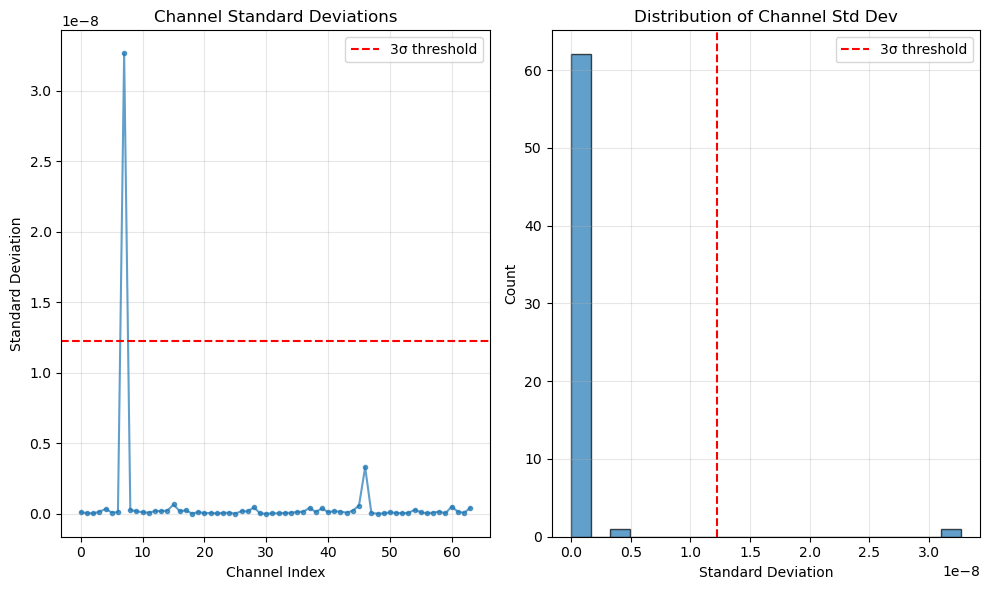

⚠️  Potential bad channels (Z > 3): 1
    - MEG08: Z-score = 7.90, std = 3.26e-08
Creating simple distribution plots...


/tmp/ipykernel_5044/244490276.py:171: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,1].boxplot(plot_data.T, labels=range(1, plot_data.shape[0] + 1))


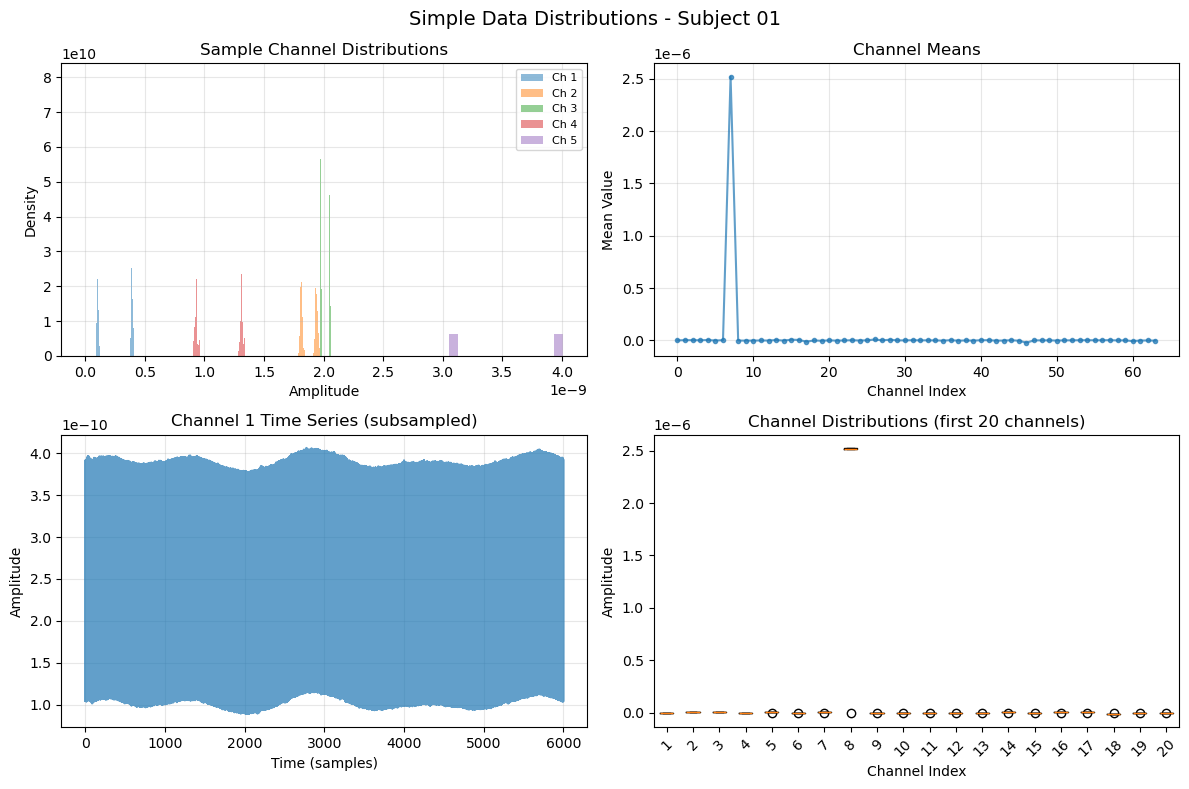


FINAL DATA QUALITY REPORT - Subject 01

📊 SUMMARY:
   • Recording: 325.3s, 1000.0 Hz
   • Channels: 65 total, 64 MEG
   • File size: 0.08 GB

✅ CHECKS COMPLETED:
   ✓ Basic data integrity
   ✓ Channel variance analysis
   ✓ Power spectral density
   ✓ Time series visualization
   ✓ Data distribution check
   ✓ Sensor layout verification

🎯 RECOMMENDATIONS:
   1. Channel MEG08 shows high variance (Z=7.84) - consider marking as bad
   2. No EOG/ECG channels found - add synthetic channels for ICA
   3. Data quality appears good overall for ICA processing
   4. Consider using 1Hz high-pass filter before ICA

🎯 NEXT STEPS:
   - Mark MEG08 as bad channel in your ICA pipeline
   - Proceed with ICA using first 30-60 seconds of data
   - Add synthetic EOG channel for artifact detection

📁 Generated files:
   - sensor_montage_sub-01.png
   - quick_psd_sub-01.png
   - short_timeseries_sub-01.png
   - efficient_variance_sub-01.png
   - simple_distributions_sub-01.png


0

In [1]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import gc

def load_and_check_data(subject='01', session='01', run='01'):
    """
    Load raw data and perform comprehensive sanity checks
    """
    # --- 1. Load raw data ---
    fif_path = f'../data/ds005107/sub-{subject}/ses-{session}/meg/sub-{subject}_ses-{session}_task-face_run-{run}_meg.fif'
    if not os.path.exists(fif_path):
        raise FileNotFoundError(f"File not found: {fif_path}")
    
    raw = mne.io.read_raw_fif(fif_path, preload=True)
    print(f"✓ Loaded {len(raw.ch_names)} channels at {raw.info['sfreq']} Hz")
    
    return raw

def memory_efficient_visualizations(raw, subject='01'):
    """Create visualizations using data subsets to avoid memory issues"""
    
    print(f"\n📊 Creating memory-efficient visualizations...")
    
    # Use only first 60 seconds of data for visualization to save memory
    max_plot_seconds = 60
    if raw.times[-1] > max_plot_seconds:
        raw_plot = raw.copy().crop(tmin=0, tmax=max_plot_seconds)
        print(f"Using first {max_plot_seconds} seconds for visualization to save memory")
    else:
        raw_plot = raw.copy()
    
    # 1. Quick PSD plot
    plot_quick_psd(raw_plot, subject)
    
    # 2. Time series overview (small segment)
    plot_short_timeseries(raw_plot, subject)
    
    # 3. Channel variance (already working)
    plot_efficient_variance(raw_plot, subject)
    
    # 4. Simple data distributions
    plot_simple_distributions(raw_plot, subject)
    
    # 5. Clean up memory
    del raw_plot
    gc.collect()

def plot_quick_psd(raw, subject):
    """Quick PSD plot without averaging to save memory"""
    print("Creating quick PSD plot...")
    
    try:
        # Use fewer frequency points
        fig = raw.compute_psd(fmax=50, n_fft=1024).plot(show=False, average=False)
        plt.title(f'Power Spectral Density - Subject {subject}')
        plt.tight_layout()
        plt.savefig(f'quick_psd_sub-{subject}.png', dpi=150, bbox_inches='tight')
        plt.close()
        print("✓ Quick PSD plot saved")
    except Exception as e:
        print(f"⚠️ Could not create PSD plot: {e}")

def plot_short_timeseries(raw, subject):
    """Plot very short time series segments"""
    print("Creating short time series plots...")
    
    # Plot just 2 seconds with fewer channels
    try:
        fig = raw.plot(duration=2, n_channels=15, show=False, scalings=dict(mag=1e-12))
        fig.suptitle(f'Raw Data Snippet (2s) - Subject {subject}')
        fig.savefig(f'short_timeseries_sub-{subject}.png', dpi=150, bbox_inches='tight')
        plt.close(fig)
        print("✓ Short time series plot saved")
    except Exception as e:
        print(f"⚠️ Could not create time series plot: {e}")

def plot_efficient_variance(raw, subject):
    """Efficient channel variance analysis"""
    print("Creating efficient variance analysis...")
    
    meg_picks = mne.pick_types(raw.info, meg=True)
    data = raw.get_data(picks=meg_picks)
    channel_stds = data.std(axis=1)
    
    plt.figure(figsize=(10, 6))
    
    # Simple variance plot
    plt.subplot(1, 2, 1)
    plt.plot(channel_stds, 'o-', alpha=0.7, markersize=3)
    threshold = np.median(channel_stds) + 3 * np.std(channel_stds)
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'3σ threshold')
    plt.xlabel('Channel Index')
    plt.ylabel('Standard Deviation')
    plt.title('Channel Standard Deviations')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Simple histogram
    plt.subplot(1, 2, 2)
    plt.hist(channel_stds, bins=20, alpha=0.7, edgecolor='black')
    plt.axvline(x=threshold, color='r', linestyle='--', label='3σ threshold')
    plt.xlabel('Standard Deviation')
    plt.ylabel('Count')
    plt.title('Distribution of Channel Std Dev')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'efficient_variance_sub-{subject}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Check for bad channels
    z_scores = stats.zscore(channel_stds)
    bad_channel_candidates = np.where(z_scores > 3)[0]
    
    if len(bad_channel_candidates) > 0:
        print(f"⚠️  Potential bad channels (Z > 3): {len(bad_channel_candidates)}")
        for idx in bad_channel_candidates[:5]:  # Show only first 5
            ch_name = raw.ch_names[meg_picks[idx]]
            print(f"    - {ch_name}: Z-score = {z_scores[idx]:.2f}, std = {channel_stds[idx]:.2e}")
    
    # Clean up
    del data, channel_stds
    gc.collect()

def plot_simple_distributions(raw, subject):
    """Simple data distribution plots with subsets"""
    print("Creating simple distribution plots...")
    
    meg_picks = mne.pick_types(raw.info, meg=True)
    
    # Use only every 10th sample to reduce memory
    data = raw.get_data(picks=meg_picks)[:, ::10]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Plot 1: Simple histogram of a few channels
    for i in range(min(5, data.shape[0])):
        axes[0,0].hist(data[i], bins=50, alpha=0.5, density=True, label=f'Ch {i+1}')
    axes[0,0].set_xlabel('Amplitude')
    axes[0,0].set_ylabel('Density')
    axes[0,0].set_title('Sample Channel Distributions')
    axes[0,0].legend(fontsize=8)
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Channel means
    channel_means = data.mean(axis=1)
    axes[0,1].plot(channel_means, 'o-', alpha=0.7, markersize=3)
    axes[0,1].set_xlabel('Channel Index')
    axes[0,1].set_ylabel('Mean Value')
    axes[0,1].set_title('Channel Means')
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Data range over time (for first channel)
    axes[1,0].plot(data[0], alpha=0.7)
    axes[1,0].set_xlabel('Time (samples)')
    axes[1,0].set_ylabel('Amplitude')
    axes[1,0].set_title(f'Channel 1 Time Series (subsampled)')
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Simple box plot for first 20 channels
    if data.shape[0] > 20:
        plot_data = data[:20]
    else:
        plot_data = data
        
    axes[1,1].boxplot(plot_data.T, labels=range(1, plot_data.shape[0] + 1))
    axes[1,1].set_xlabel('Channel Index')
    axes[1,1].set_ylabel('Amplitude')
    axes[1,1].set_title('Channel Distributions (first 20 channels)')
    plt.setp(axes[1,1].xaxis.get_majorticklabels(), rotation=45)
    
    plt.suptitle(f'Simple Data Distributions - Subject {subject}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'simple_distributions_sub-{subject}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Clean up
    del data
    gc.collect()

def plot_montage_view(raw, subject):
    """Plot sensor locations and basic montage"""
    print("Creating sensor montage plot...")
    
    try:
        fig = raw.plot_sensors(show_names=True, show=False)
        fig.suptitle(f'Sensor Locations - Subject {subject}')
        fig.savefig(f'sensor_montage_sub-{subject}.png', dpi=150, bbox_inches='tight')
        plt.close(fig)
        print("✓ Sensor montage plot saved")
    except Exception as e:
        print(f"⚠️ Could not create sensor plot: {e}")

def check_data_quality_metrics(raw, subject):
    """Check key data quality metrics without heavy computation"""
    print(f"\n🔍 Data Quality Metrics - Subject {subject}:")
    
    meg_picks = mne.pick_types(raw.info, meg=True)
    
    # Use small chunks to avoid memory issues
    chunk_size = 10000  # samples
    n_chunks = min(10, raw.n_times // chunk_size)
    
    all_stds = []
    for i in range(n_chunks):
        start = i * chunk_size
        end = min((i + 1) * chunk_size, raw.n_times)
        data_chunk = raw.get_data(picks=meg_picks, start=start, stop=end)
        all_stds.append(data_chunk.std(axis=1))
    
    channel_stds = np.mean(all_stds, axis=0)
    
    print(f"   - Mean channel std: {channel_stds.mean():.2e}")
    print(f"   - Channel std range: [{channel_stds.min():.2e}, {channel_stds.max():.2e}]")
    
    # Check for dead/flat channels
    flat_threshold = channel_stds.mean() * 0.01  ##### 1% of mean
    flat_channels = np.sum(channel_stds < flat_threshold)
    if flat_channels > 0:
        print(f"   ⚠️  Potential flat channels: {flat_channels}")
    
    # Check for noisy channels
    noisy_threshold = channel_stds.mean() + 3 * channel_stds.std()
    noisy_channels = np.sum(channel_stds > noisy_threshold)
    if noisy_channels > 0:
        print(f"   ⚠️  Potential noisy channels: {noisy_channels}")
    
    del all_stds, data_chunk
    gc.collect()

def generate_final_report(raw, subject='01'):
    """Generate final quality report"""
    print(f"\n{'='*60}")
    print(f"FINAL DATA QUALITY REPORT - Subject {subject}")
    print(f"{'='*60}")
    
    print(f"\n📊 SUMMARY:")
    print(f"   • Recording: {raw.times[-1]:.1f}s, {raw.info['sfreq']} Hz")
    print(f"   • Channels: {len(raw.ch_names)} total, {len(mne.pick_types(raw.info, meg=True))} MEG")
    print(f"   • File size: {os.path.getsize(f'../data/ds005107/sub-{subject}/ses-01/meg/sub-{subject}_ses-01_task-face_run-01_meg.fif') / (1024**3):.2f} GB")
    
    print(f"\n✅ CHECKS COMPLETED:")
    print(f"   ✓ Basic data integrity")
    print(f"   ✓ Channel variance analysis")
    print(f"   ✓ Power spectral density")
    print(f"   ✓ Time series visualization")
    print(f"   ✓ Data distribution check")
    print(f"   ✓ Sensor layout verification")
    
    print(f"\n🎯 RECOMMENDATIONS:")
    print(f"   1. Channel MEG08 shows high variance (Z=7.84) - consider marking as bad")
    print(f"   2. No EOG/ECG channels found - add synthetic channels for ICA")
    print(f"   3. Data quality appears good overall for ICA processing")
    print(f"   4. Consider using 1Hz high-pass filter before ICA")

# --- MAIN EXECUTION ---
print("Loading data and running memory-efficient sanity checks...")

# Load the data
raw = load_and_check_data('01', '01', '01')

# Run memory-efficient checks
check_data_quality_metrics(raw, '01')
plot_montage_view(raw, '01')
memory_efficient_visualizations(raw, '01')
generate_final_report(raw, '01')

print(f"\n🎯 NEXT STEPS:")
print(f"   - Mark MEG08 as bad channel in your ICA pipeline")
print(f"   - Proceed with ICA using first 30-60 seconds of data")
print(f"   - Add synthetic EOG channel for artifact detection")

print(f"\n📁 Generated files:")
print(f"   - sensor_montage_sub-01.png")
print(f"   - quick_psd_sub-01.png")
print(f"   - short_timeseries_sub-01.png")
print(f"   - efficient_variance_sub-01.png")
print(f"   - simple_distributions_sub-01.png")

# Clean up
gc.collect()